In [1]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from paper.systems.simplesystem import simplesystem
from ctse.systems.ct_system import ct_system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from paper.topic.spectrum import signal_fft, psd
from mdi import snr
from syscore.fileutils import get_filename_for_package

system = ct_system()
rawdata = system.rawdata
data = system.data

2022-11-28 10:09:02 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2022-11-28 10:09:02 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)


In [91]:
# 
term = 50

inss = [ins for ins in system.get_instrument_list()]
snrs = [data.daily_prices(ins).dropna().rolling(term, min_periods=term).apply(snr).rename(ins) for ins in inss]
ins_mdi_df = pd.concat(snrs, axis=1)

backtest = pd.read_csv(get_filename_for_package('ctse.data.strategy_backtest.market_long_short.csv'), encoding='GBK')
backtest.index = backtest.iloc[:, 0]
tmp = pd.concat([backtest.loc['夏普'].iloc[2:].sort_values().rename('sharpe'), ins_mdi_df.mean(axis=0).rename('mdi')], axis=1).dropna()
display(tmp)
# tmp.plot.scatter(x='mdi', y='sharpe')

,sharpe,mdi
CF,0.503446,0.148033
ZN,0.583725,0.140430
C,0.727083,0.153398
JD,0.756226,0.153877
RM,0.804664,0.124961
CU,0.811331,0.145147
RU,0.869755,0.153148
M,0.90064,0.138101
OI,0.903134,0.150376
MA,0.920668,0.145543


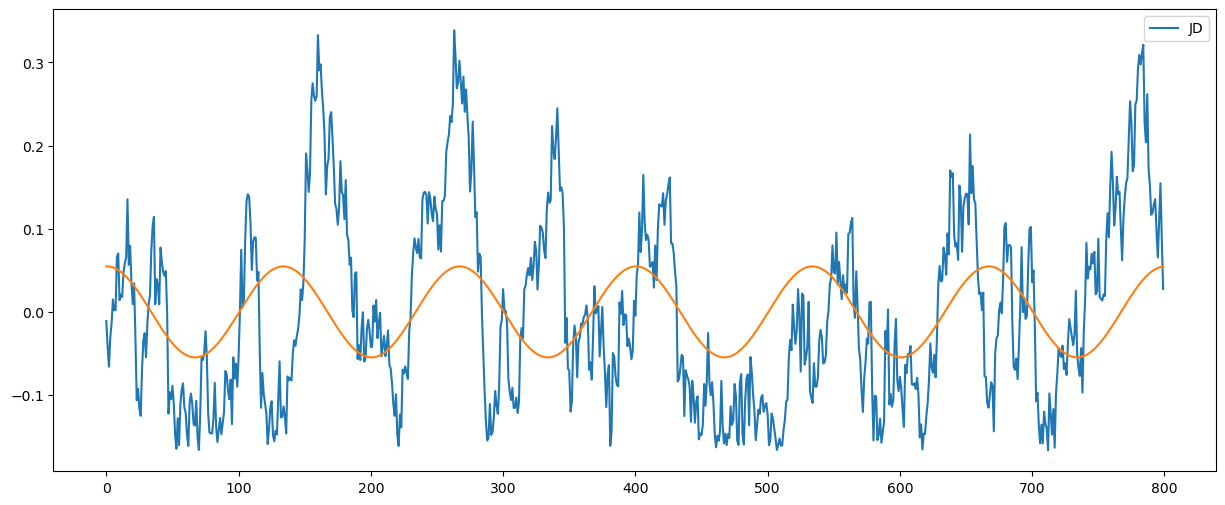

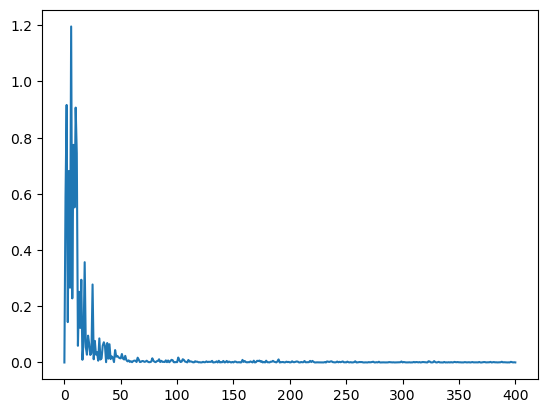

In [191]:
from scipy.fft import rfft, irfft, fftfreq
from scipy.signal import detrend, stft
import numpy as np

sampled_signal = ins_mdi_df['JD'].dropna().tail(200 * 4)
# sampled_signal = ins_mdi_df.sample(1, axis=1).dropna().iloc[:,0].tail(200 * 10)
ins = sampled_signal.name
sampled_signal = detrend(sampled_signal, type='constant')
plt.figure(figsize = (15,6))
_ = plt.plot(sampled_signal, label=ins)
_ = plt.legend()

# f, t, Zxx = stft(sampled_signal, 1)
# plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
fft_signal = rfft(sampled_signal)
psd = fft_signal * np.conjugate(fft_signal) / len(fft_signal)
filtered_signal = fft_signal * (psd>1)
_ = plt.plot(irfft(filtered_signal))
_ = plt.show()
_ = plt.plot(psd)
# psd(sampled_signal, 1, 0.0008)
# sampled_signal.plot(legend=True)



# Cart_fft= fft(sampled_signal.values)
# Cart_psd=np.abs(Cart_fft)**2
# fft_freq=fftfreq(len(Cart_psd))
# k=fft_freq>0
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.plot(fft_freq, 10 * np.log10(Cart_psd))
# ax.set_xlim(5,7.5)
# ax.set_ylim(60,1000)
# ax.set_xlabel('Frequency (1/year)')
# ax.set_ylabel('PSD (dB)')


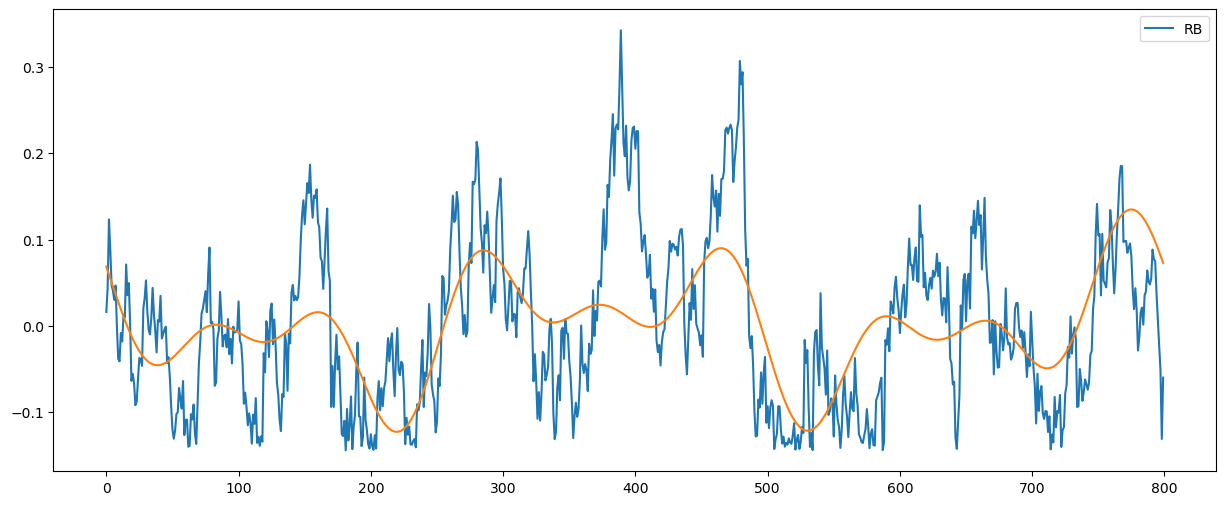

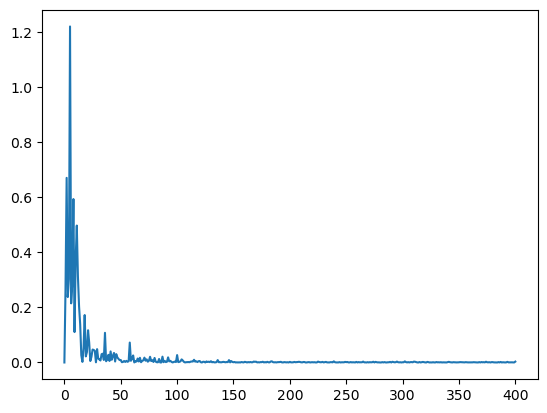

In [203]:
from scipy.fft import rfft, irfft, fftfreq
from scipy.signal import detrend, stft
import numpy as np

sampled_signal = ins_mdi_df['RB'].dropna().tail(200 * 4)
# sampled_signal = ins_mdi_df.sample(1, axis=1).dropna().iloc[:,0].tail(200 * 10)
ins = sampled_signal.name
sampled_signal = detrend(sampled_signal, type='constant')
plt.figure(figsize = (15,6))
_ = plt.plot(sampled_signal, label=ins)
_ = plt.legend()

# f, t, Zxx = stft(sampled_signal, 1)
# plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
fft_signal = rfft(sampled_signal)
psd = fft_signal * np.conjugate(fft_signal) / len(fft_signal)
filtered_signal = fft_signal * (psd>0.5)
_ = plt.plot(irfft(filtered_signal))
_ = plt.show()
_ = plt.plot(psd)
# psd(sampled_signal, 1, 0.0008)
# sampled_signal.plot(legend=True)



# Cart_fft= fft(sampled_signal.values)
# Cart_psd=np.abs(Cart_fft)**2
# fft_freq=fftfreq(len(Cart_psd))
# k=fft_freq>0
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.plot(fft_freq, 10 * np.log10(Cart_psd))
# ax.set_xlim(5,7.5)
# ax.set_ylim(60,1000)
# ax.set_xlabel('Frequency (1/year)')
# ax.set_ylabel('PSD (dB)')


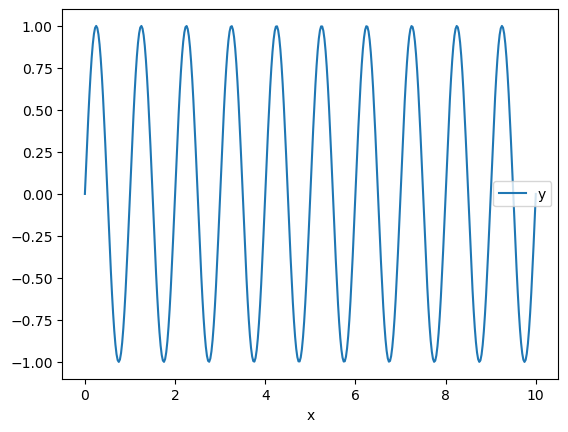

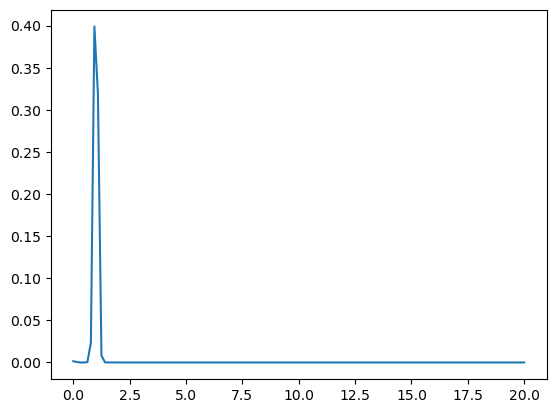

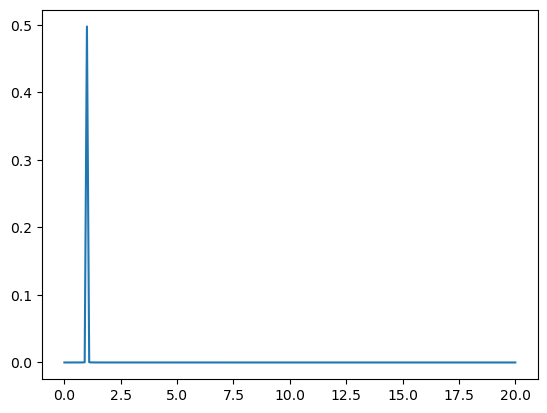

In [4]:
import numpy as np
from scipy.signal import welch, periodogram
import pandas as pd
import matplotlib.pyplot as plt

T = 1
amplitude = 1
frequency = 1 / T
T_sample_N = 40
sampling_frequency = T_sample_N / T
N_periods = 10
x_value = np.linspace(0, T * N_periods, T_sample_N * N_periods)
y_values = amplitude*np.sin(2*np.pi*frequency*x_value)
df = pd.DataFrame({
    'x': x_value,
    'y': y_values
})
df.plot(x='x', y='y')
plt.show()

f, p = welch(y_values, sampling_frequency, scaling='spectrum')
plt.plot(f, p)
plt.show()
f2, p2 = periodogram(y_values, sampling_frequency, scaling='spectrum')
plt.plot(f2, p2)
plt.show()

In [5]:
from  sklearn.linear_model import LinearRegression

df = pd.concat([panel_mdi, rolling_return], axis=1).dropna()
df.plot.scatter(x='mdi', y='rolling_return')

model = LinearRegression()
estimator = model.fit(pd.DataFrame(df['mdi']), pd.DataFrame(df['rolling_return']))
estimator.score(pd.DataFrame(df['mdi']), pd.DataFrame(df['rolling_return']))

NameError: name 'panel_mdi' is not defined

<BarContainer object of 10 artists>

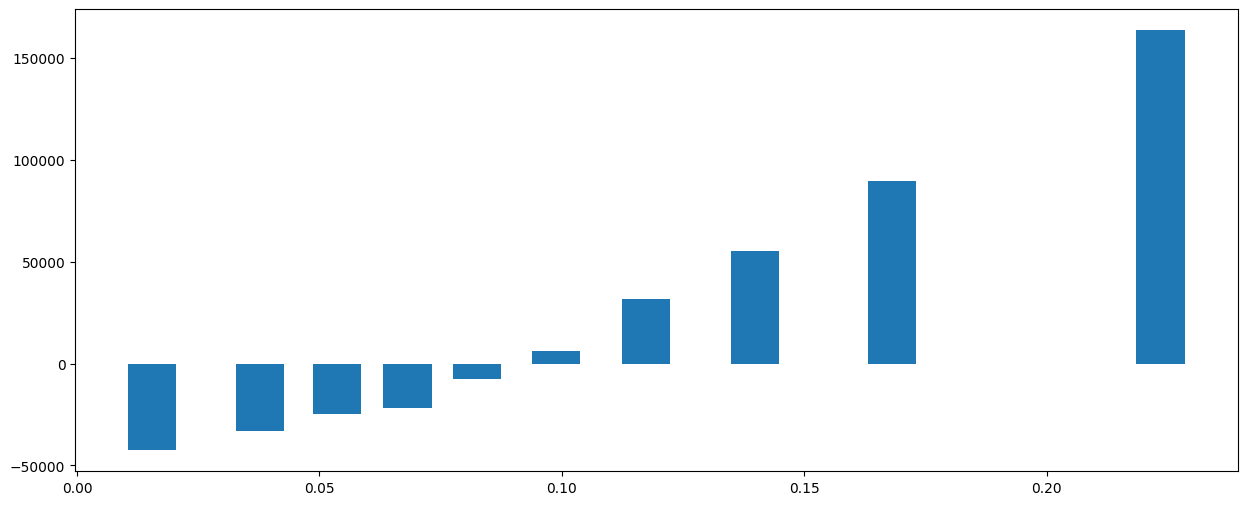

In [ ]:
import numpy as np

xs = []
ys = []
for bin in np.array_split(df.sort_values('mdi'), 10):
    xs.append(bin['mdi'].mean())
    ys.append(bin['rolling_return'].mean())
fig, ax = plt.subplots(figsize=(15,6))
ax.bar(xs, ys, width=0.01)